In [1]:
#install Kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saijasi","key":"0c0952e41686304938579abe1d4325d4"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                         title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                   146KB  2023-10-05 06:45:37          18248        395  1.0              
redpen12/employees-satisfaction-analysis                    Employee Satisfaction Survey Data                  140KB  2023-11-03 08:56:49            903         27  1.0              
nelgiriyewithana/billionaires-statistics-dataset            Billionaires Statistics Dataset (2023)             139KB  2023-09-29 13:39:28           9909        243  1.0              
js1js2js3js4js5/world-trading-dataset-2000-2022             World Trading Dataset (20

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 668M/675M [00:04<00:00, 166MB/s]
100% 675M/675M [00:04<00:00, 156MB/s]


In [8]:
import zipfile

z= zipfile.ZipFile('cell-images-for-detecting-malaria.zip')
z.extractall()

In [9]:
import os, shutil
import random
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm, tqdm_notebook
import cv2
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report, precision_score, recall_score
from sklearn.linear_model import LinearRegression

import skimage
import skimage.segmentation
import copy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.imagenet_utils import decode_predictions

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0
2.14.0


In [10]:
original_dataset_parasitized = os.path.join('cell_images/cell_images', 'Parasitized/')
original_dataset_uninfected = os.path.join('cell_images/cell_images', 'Uninfected/')

In [11]:
# Create a base dir
if not os.path.isdir('healthy_and_infected'):
    base_dir = 'healthy_and_infected'
    os.mkdir(base_dir)

In [12]:
# Make train, valid and test directories
#train
if not os.path.isdir('healthy_and_infected/train'):
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
#valid
if not os.path.isdir('healthy_and_infected/valid'):
    valid_dir = os.path.join(base_dir, 'valid')
    os.mkdir(valid_dir)
#test
if not os.path.isdir('healthy_and_infected/test'):
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

In [13]:
# Make directories for infected images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/inf'):
    infected_trn_dir = os.path.join(train_dir, 'inf')
    os.mkdir(infected_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/inf'):
    infected_valid_dir = os.path.join(valid_dir, 'inf')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('healthy_and_infected/test/inf'):
    infected_test_dir = os.path.join(test_dir, 'inf')
    os.mkdir(infected_test_dir)

In [14]:
# Make directories for healthy images in each of the train, valid and test directories
if not os.path.isdir('healthy_and_infected/train/healthy'):
    healthy_trn_dir = os.path.join(train_dir, 'healthy')
    os.mkdir(healthy_trn_dir)

if not os.path.isdir('healthy_and_infected/valid/healthy'):
    healthy_valid_dir = os.path.join(valid_dir, 'healthy')
    os.mkdir(healthy_valid_dir)

if not os.path.isdir('healthy_and_infected/test/healthy'):
    healthy_test_dir = os.path.join(test_dir, 'healthy')
    os.mkdir(healthy_test_dir)

In [15]:
files1 = os.listdir('cell_images/cell_images/Parasitized/')
fnames1 = []
for i in range(13779):
    fnames1.append(files1[i])

if 'Thumbs.db' in fnames1:
    os.remove('cell_images/cell_images/Parasitized/Thumbs.db')

files2 = os.listdir('cell_images/cell_images/Uninfected/')
fnames2 = []
for i in range(13779):
    fnames2.append(files2[i])

if 'Thumbs.db' in fnames2:
    os.remove('cell_images/cell_images/Uninfected/Thumbs.db')

In [16]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_trn_dir, fname)
    shutil.copyfile(src,dst)

In [17]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src,dst)

In [18]:
files = os.listdir('cell_images/cell_images/Parasitized/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_parasitized, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src,dst)

In [19]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_trn_dir, fname)
    shutil.copyfile(src,dst)

In [20]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(11023, 12401):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src,dst)

In [21]:
files = os.listdir('cell_images/cell_images/Uninfected/')
fnames = []
for i in range(12401, 13779):
    fnames.append(files[i])

for fname in fnames:
    src = os.path.join(original_dataset_uninfected, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src,dst)

In [22]:
print("{} Infected training images:".format(len(os.listdir(infected_trn_dir))))
print("{} Uninfected training images:".format(len(os.listdir(healthy_trn_dir))))
print(" {} Infected valid images:".format(len(os.listdir(infected_valid_dir))))
print(" {} Uninfected valid images:".format(len(os.listdir(healthy_valid_dir))))
print(" {} Infected testing images:".format(len(os.listdir(infected_test_dir))))
print(" {} Uninfected testing images:".format(len(os.listdir(healthy_test_dir))))

11023 Infected training images:
11023 Uninfected training images:
 1378 Infected valid images:
 1378 Uninfected valid images:
 1378 Infected testing images:
 1378 Uninfected testing images:


In [23]:
# Train
infected_trn_fpaths = [os.path.join(infected_trn_dir, fpath) for fpath in os.listdir(infected_trn_dir)]
healthy_trn_fpaths = [os.path.join(healthy_trn_dir, fpath) for fpath in os.listdir(healthy_trn_dir)]

# Valid
infected_valid_fpaths = [os.path.join(infected_valid_dir, fpath) for fpath in os.listdir(infected_valid_dir)]
healthy_valid_fpaths = [os.path.join(healthy_valid_dir, fpath) for fpath in os.listdir(healthy_valid_dir)]

# Test
infected_test_fpaths = [os.path.join(infected_test_dir, fpath) for fpath in os.listdir(infected_test_dir)]
healthy_test_fpaths = [os.path.join(healthy_test_dir, fpath) for fpath in os.listdir(healthy_test_dir)]

In [24]:
def get_img_shape(idx, img, total_num_images):

    if idx%2000 ==0 or idx == (total_num_images-1):
        print("working on img {}".format(idx))
    return cv2.imread(img).shape

data_inp = [(idx, img, len(infected_trn_fpaths + healthy_trn_fpaths)) for idx, img in enumerate(infected_trn_fpaths + healthy_trn_fpaths)]

train_img_dims_map = list(map(get_img_shape, [input[0] for input in data_inp],
    [input[1] for input in data_inp],
    [input[2] for input in data_inp]))

working on img 0
working on img 2000
working on img 4000
working on img 6000
working on img 8000
working on img 10000
working on img 12000
working on img 14000
working on img 16000
working on img 18000
working on img 20000
working on img 22000
working on img 22045


In [25]:
print('Min Dimensions:           {}'.format(np.min(train_img_dims_map, axis=0)))
print('Avg Dimensions:           {}'.format(np.mean(train_img_dims_map, axis=0)))
print('Median Dimensions:        {}'.format(np.median(train_img_dims_map, axis=0)))
print('Most Frequent Dimensions: {}'.format(stats.mode(train_img_dims_map, axis=0)[0]))
print('Max Dimensions:           {}'.format(np.max(train_img_dims_map, axis=0)))

Min Dimensions:           [40 46  3]
Avg Dimensions:           [133.03170643 132.53025492   3.        ]
Median Dimensions:        [130. 130.   3.]
Most Frequent Dimensions: [130 130   3]
Max Dimensions:           [385 364   3]


In [26]:
infected_trn_samples = random.sample(infected_trn_fpaths, 5)
healthy_trn_samples = random.sample(healthy_trn_fpaths, 5)

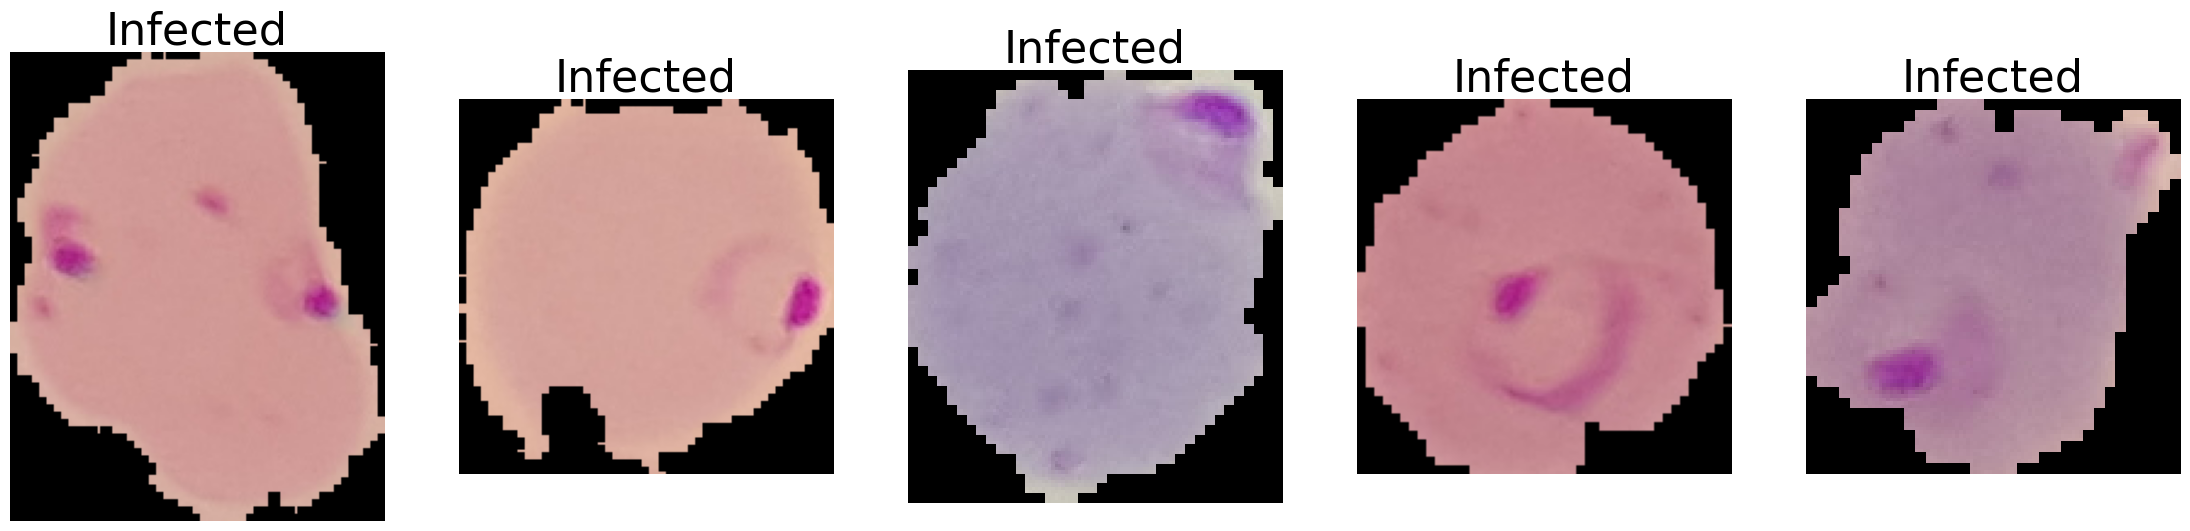

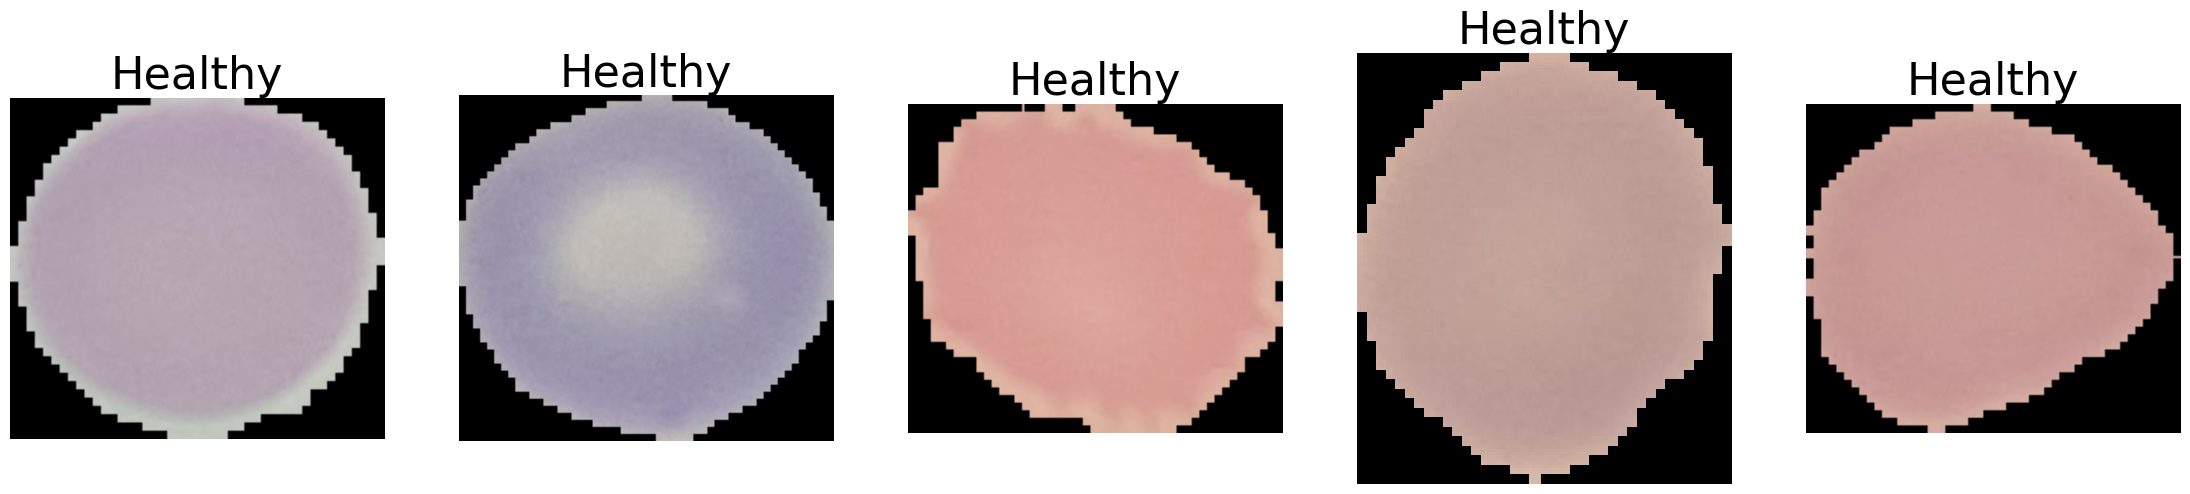

In [28]:
fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(infected_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Infected', fontsize=32)
plt.show()


fig =plt.figure(figsize=(28,14))
columns=5
rows=1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mpimg.imread(healthy_trn_samples[i-1]))
    plt.axis('off')
    plt.title('Healthy', fontsize=32)
plt.savefig("/content/outputmalaria.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   horizontal_flip=0.4,
                                   vertical_flip=0.4,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(128,128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    batch_size=32,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42,
                                                    color_mode='rgb')

class_labels = train_generator.class_indices
class_names = {value:key for (key, value) in class_labels.items()}

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [30]:
class_labels, class_names

({'healthy': 0, 'inf': 1}, {0: 'healthy', 1: 'inf'})

In [32]:
# Instantiate VGG19 model with weights from Imagenet without the calssifier at the top
base_model = VGG19(input_shape = (128,128,3),
                   include_top = False,
                   weights = 'imagenet')
# Freeze the ConvNet to avoid weight updates
for layer in base_model.layers:
    layer.trainable=False

x = base_model.output
flat=Flatten()(x)

# Add a classifier -  a fully connected dense layers
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

# Bake a model
model_01 = Model(base_model.inputs, output)
model_01.summary()

# Call backs
filepath = 'models/malaria.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.0001)

# Define an optimizer
# Define an optimizer using legacy SGD
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)


# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [33]:
# Fit the model on the training set and train for 10 epochs
history_01 = model_01.fit(train_generator,
                          steps_per_epoch=50,
                          epochs=10,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.5344
Epoch 1: val_loss improved from inf to 0.64201, saving model to models/malaria.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 34s 399ms/step - loss: 0.7149 - accuracy: 0.5344 - val_loss: 0.6420 - val_accuracy: 0.6499 - lr: 1.0000e-04
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.6250
Epoch 2: val_loss improved from 0.64201 to 0.58764, saving model to models/malaria.h5
50/50 [==============================] - 17s 339ms/step - loss: 0.6456 - accuracy: 0.6250 - val_loss: 0.5876 - val_accuracy: 0.7544 - lr: 1.0000e-04
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.6556
Epoch 3: val_loss improved from 0.58764 to 0.56817, saving model to models/malaria.h5
50/50 [==============================] - 16s 325ms/step - loss: 0.6193 - accuracy: 0.6556 - val_loss: 0.5682 - val_accuracy: 0.7235 - lr: 1.0000e-04
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.6981
Epoch 4: val_loss improved from 0.56817 to 0.56072, saving model to models/malaria.h5
50/50 [======

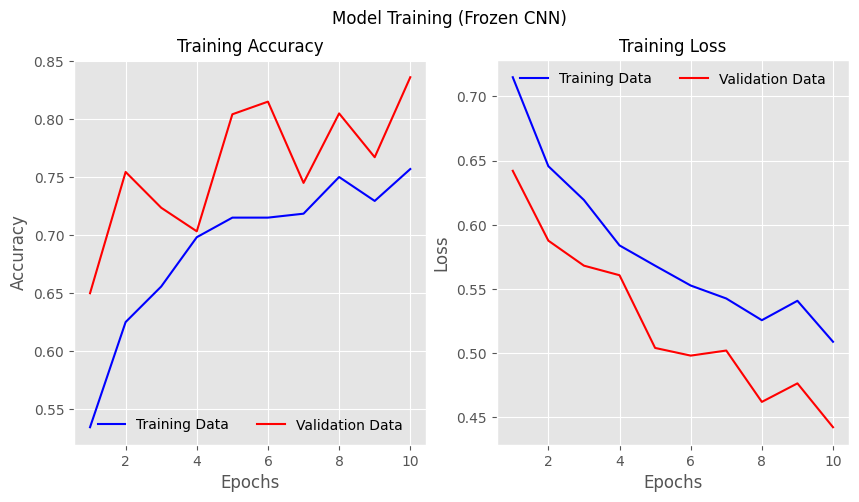

In [34]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("/content/output2.png", format='png', dpi=400, bbox_inches='tight')

In [35]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath='model_weights/vgg19_model_01.h5', overwrite=True)

In [36]:
# Resize test images similar to the train data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(128, 128),
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  seed=42,
                                                  color_mode='rgb')

Found 2756 images belonging to 2 classes.


In [37]:
# Load the saved model
model_01.load_weights('model_weights/vgg19_model_01.h5')
# Evaluate the model on the hold out validation and test datasets

# Evaluate the model on batches of validation and testing data
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print('Validation loss:     {0:.4f}'.format(vgg_val_eval_01[0]))
print('Validation accuracy: {0:.4f}'.format(vgg_val_eval_01[1]))
print('Test loss:           {0:.4f}'.format(vgg_test_eval_01[0]))
print('Test accuracy:       {0:.4f}'.format(vgg_test_eval_01[1]))

2756/2756 [==============================] - 27s 10ms/step - loss: 0.4426 - accuracy: 0.8295
Validation loss:     0.4424
Validation accuracy: 0.8360
Test loss:           0.4426
Test accuracy:       0.8295


In [38]:
filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_01 = model_01.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_01= np.argmax(vgg_predictions_01, axis=1)

2756/2756 [==============================] - 21s 7ms/step


In [39]:
# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_01,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_01 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_01),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])

              precision    recall  f1-score   support

     healthy       0.84      0.81      0.83      1378
    infected       0.82      0.85      0.83      1378

    accuracy                           0.83      2756
   macro avg       0.83      0.83      0.83      2756
weighted avg       0.83      0.83      0.83      2756



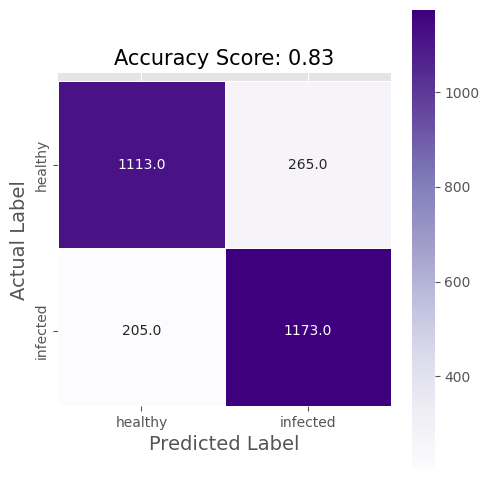

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(9,9))
sns.heatmap(vgg_conf_mat_01, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_01[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_01)-0.05, -0.05)
plt.tight_layout()

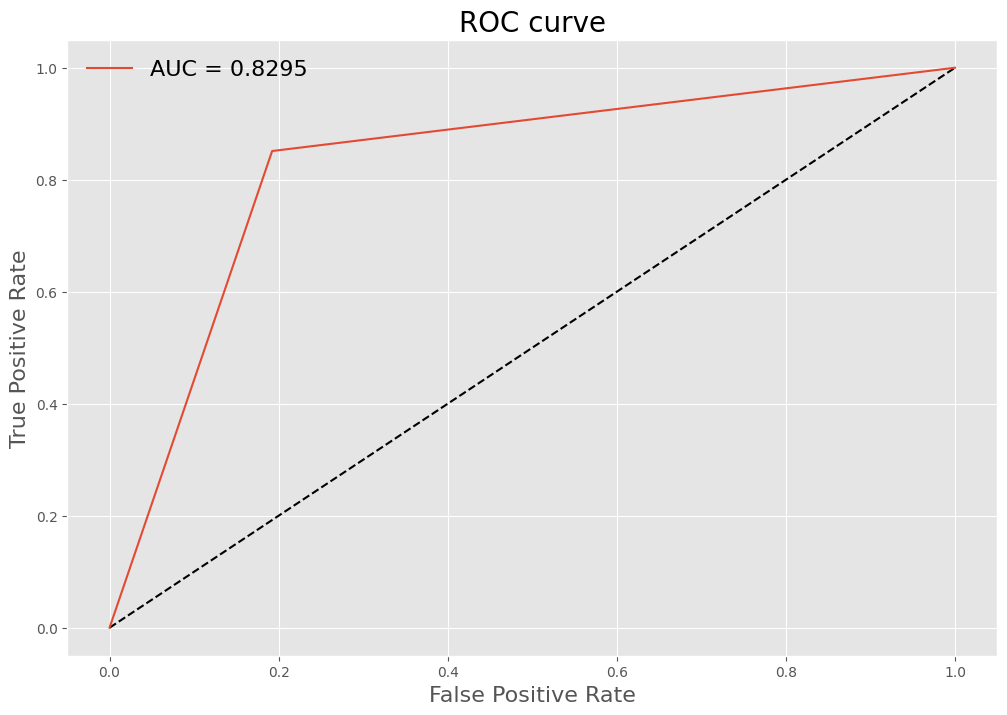

In [41]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_01)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

In [42]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output

flat=Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [44]:
# Define an optimizer using legacy SGD
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

#model_02 = Model(base_model.inputs, output)
model_02.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [45]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=10, callbacks = [es, cp, lrr], validation_data = valid_generator)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.7125
Epoch 1: val_loss did not improve from 0.44239
10/10 [==============================] - 13s 980ms/step - loss: 0.5260 - accuracy: 0.7125 - val_loss: 0.4652 - val_accuracy: 0.7703 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.7406
Epoch 2: val_loss improved from 0.44239 to 0.42738, saving model to models/malaria.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 12s 1s/step - loss: 0.5123 - accuracy: 0.7406 - val_loss: 0.4274 - val_accuracy: 0.8469 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7719
Epoch 3: val_loss improved from 0.42738 to 0.42205, saving model to models/malaria.h5
10/10 [==============================] - 8s 828ms/step - loss: 0.4901 - accuracy: 0.7719 - val_loss: 0.4221 - val_accuracy: 0.8298 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.7531
Epoch 4: val_loss improved from 0.42205 to 0.41272, saving model to models/malaria.h5
10/10 [==============================] - 9s 943ms/step - loss: 0.4897 - accuracy: 0.7531 - val_loss: 0.4127 - val_accuracy: 0.8447 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.5018 - accuracy: 0.7656
Epoch 5: val_loss did not improve from 0.41272
10/10 [==============================] - 7s 740ms/step - 

In [46]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath='model_weights/vgg19_model_02.h5', overwrite=True)

2756/2756 [==============================] - 26s 10ms/step - loss: 0.3949 - accuracy: 0.8258
Validation loss:     0.3993414342403412
Validation accuracy: 0.8164005875587463
Test loss:           0.39487743377685547
Test accuracy:       0.8258345723152161
2756/2756 [==============================] - 21s 8ms/step
              precision    recall  f1-score   support

     healthy       0.76      0.96      0.85      1378
    infected       0.94      0.69      0.80      1378

    accuracy                           0.83      2756
   macro avg       0.85      0.83      0.82      2756
weighted avg       0.85      0.83      0.82      2756



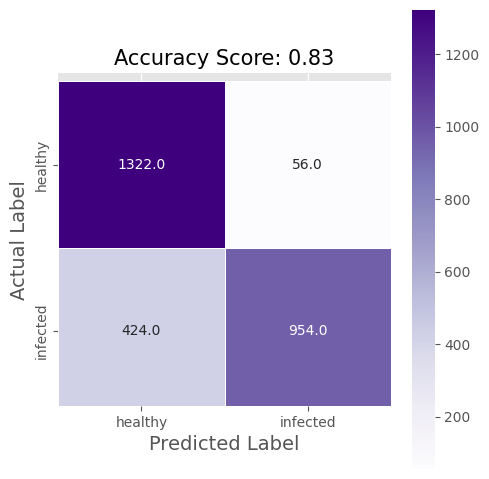

In [47]:
# Load the saved model
model_02.load_weights('model_weights/vgg19_model_02.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print('Validation loss:     {}'.format(vgg_val_eval_02[0]))
print('Validation accuracy: {}'.format(vgg_val_eval_02[1]))
print('Test loss:           {}'.format(vgg_test_eval_02[0]))
print('Test accuracy:       {}'.format(vgg_test_eval_02[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_02 = model_02.predict(test_generator,
                                                steps = nb_samples,
                                                verbose=1)
vgg_pred_labels_02 = np.argmax(vgg_predictions_02, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_02,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_02 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_02),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_02, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_02[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_02)-0.05, -0.05)
plt.tight_layout()

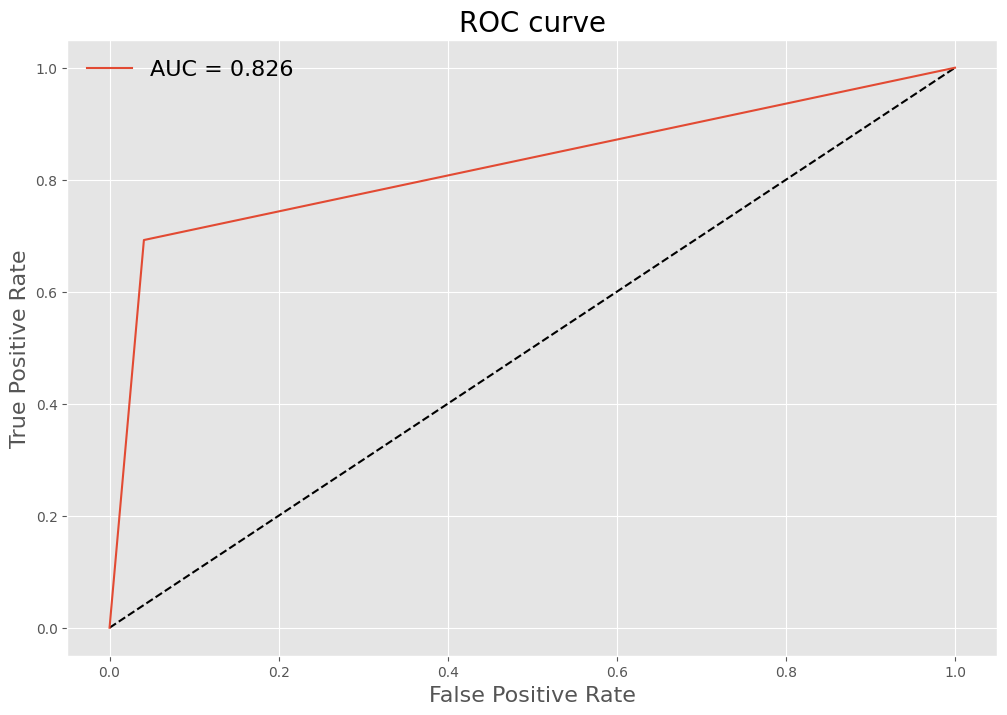

In [48]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_02)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

In [50]:
# Build the network
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat=Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights('model_weights/vgg19_model_02.h5')

# Define an optimizer using legacy SGD
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history_03 = model_03.fit(train_generator,
                          steps_per_epoch=100,
                          epochs=35,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator)

Epoch 1/35
100/100 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8315
Epoch 1: val_loss improved from 0.38366 to 0.20846, saving model to models/malaria.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 41s 331ms/step - loss: 0.3732 - accuracy: 0.8315 - val_loss: 0.2085 - val_accuracy: 0.9227 - lr: 1.0000e-04
Epoch 2/35
100/100 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8731
Epoch 2: val_loss improved from 0.20846 to 0.18566, saving model to models/malaria.h5
100/100 [==============================] - 30s 304ms/step - loss: 0.3266 - accuracy: 0.8731 - val_loss: 0.1857 - val_accuracy: 0.9376 - lr: 1.0000e-04
Epoch 3/35
100/100 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8749
Epoch 3: val_loss improved from 0.18566 to 0.15837, saving model to models/malaria.h5
100/100 [==============================] - 32s 316ms/step - loss: 0.3234 - accuracy: 0.8749 - val_loss: 0.1584 - val_accuracy: 0.9474 - lr: 1.0000e-04
Epoch 4/35
100/100 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.8897
Epoch 4: val_loss did not improve from 0.15837
100/100 [==============================]

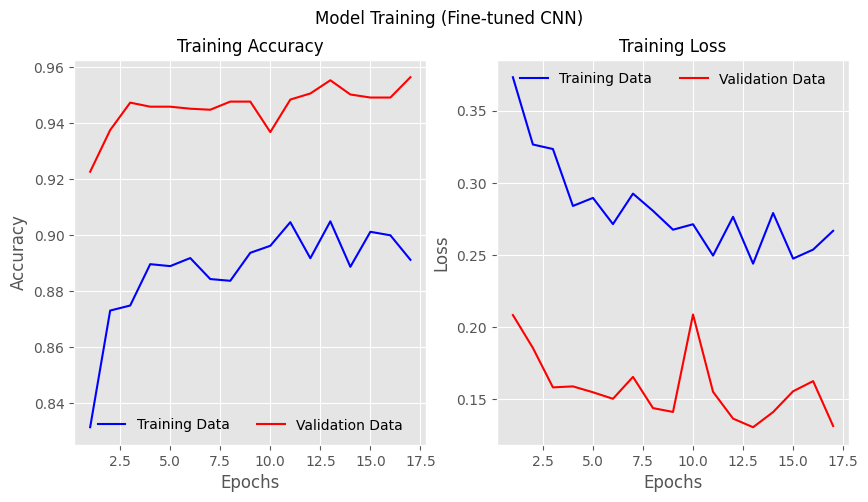

In [52]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle("Model Training (Fine-tuned CNN)", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("/content/output3.png", format='png', dpi=400, bbox_inches='tight')

In [53]:
# save model
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath='model_weights/vgg_unfrozen.h5', overwrite=True)

2756/2756 [==============================] - 27s 10ms/step - loss: 0.1267 - accuracy: 0.9543
Validation loss     :0.1316
Validation accuracy :0.9565
Test loss           :0.1267
Test accuracy       :0.9543
2756/2756 [==============================] - 21s 7ms/step
              precision    recall  f1-score   support

     healthy       0.93      0.98      0.96      1378
    infected       0.98      0.93      0.95      1378

    accuracy                           0.95      2756
   macro avg       0.96      0.95      0.95      2756
weighted avg       0.96      0.95      0.95      2756



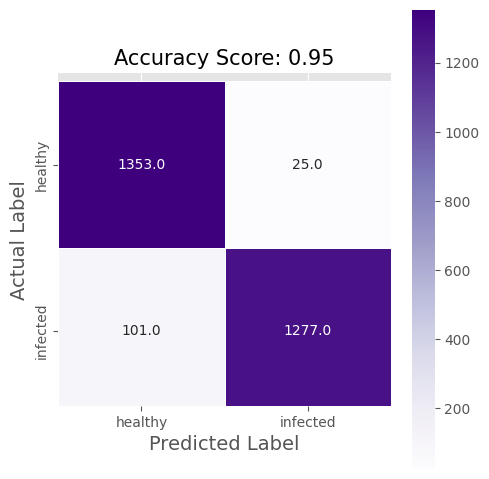

In [54]:
# Load the saved model
model_03.load_weights('model_weights/vgg_unfrozen.h5')
# Evaluate the model on the hold out validation and test datasets

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print('Validation loss     :{0:.4f}'.format(vgg_val_eval_03[0]))
print('Validation accuracy :{0:.4f}'.format(vgg_val_eval_03[1]))
print('Test loss           :{0:.4f}'.format(vgg_test_eval_03[0]))
print('Test accuracy       :{0:.4f}'.format(vgg_test_eval_03[1]))


filenames = test_generator.filenames
nb_samples = len(filenames)
vgg_predictions_03 = model_03.predict(test_generator,
                                      steps = nb_samples,
                                      verbose=1)
vgg_pred_labels_03 = np.argmax(vgg_predictions_03, axis=1)


# Classification Report
print(classification_report(test_generator.classes, vgg_pred_labels_03,
                            target_names=['healthy', 'infected']))
vgg_conf_mat_03 = pd.DataFrame(confusion_matrix(test_generator.classes, vgg_pred_labels_03),
                        index=['healthy', 'infected'],
                        columns=['healthy', 'infected'])


fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(vgg_conf_mat_03, annot=True, fmt=".1f", linewidths=0.5, square=True, cmap='Purples')
ax.set_ylabel("Actual Label", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=14)
all_sample_title="Accuracy Score: {0:.2f}".format(vgg_test_eval_03[1])
ax.set_title(all_sample_title, size=15)
ax.set_ylim(len(vgg_conf_mat_03)-0.05, -0.05)
plt.tight_layout()

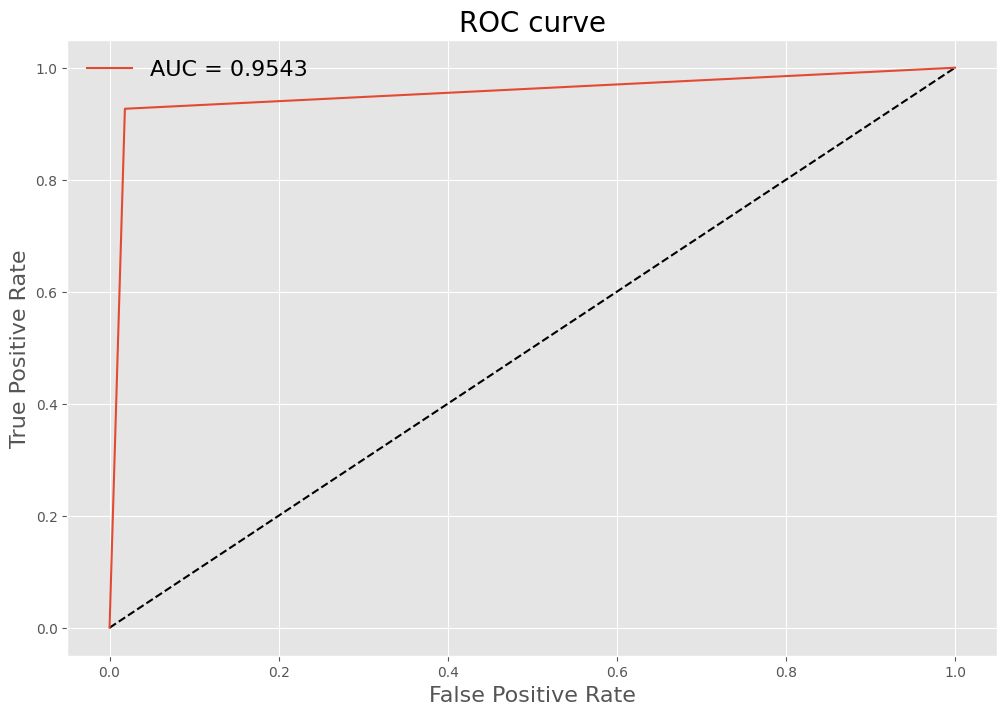

In [55]:
# AUC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, vgg_pred_labels_03)
area_under_curve = auc(false_positive_rate, true_positive_rate)

# Plot AUC Curve
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([0,1], [0,1], 'k--')
ax.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f}'.format(area_under_curve))
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title("ROC curve", fontsize=20)
ax.legend(frameon=False, loc='best', ncol=1, fontsize=16)

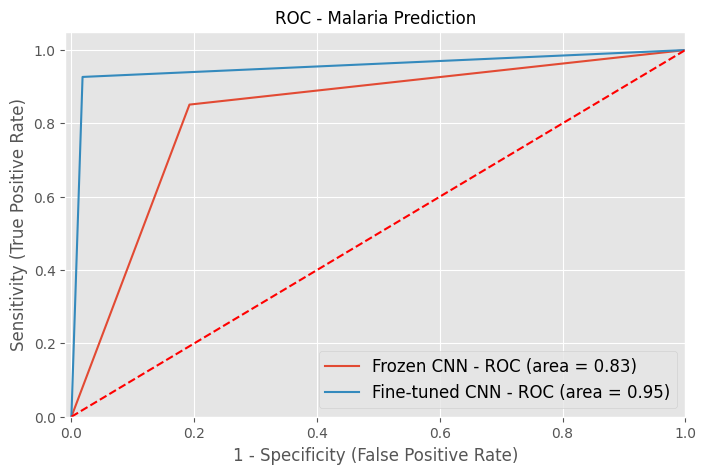

In [57]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
    'roc': vgg_pred_labels_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
    'roc': vgg_pred_labels_03,
}
]
for m in models:
    model = m['model']
    false_positive_rate, true_positive_rate, threshold = roc_curve(test_generator.classes, m['roc'])
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='%s - ROC (area = %0.2f)' % (m['label'], area_under_curve))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Malaria Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("/content/output4.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

[79.86, 95.65]
[79.86, 95.65]


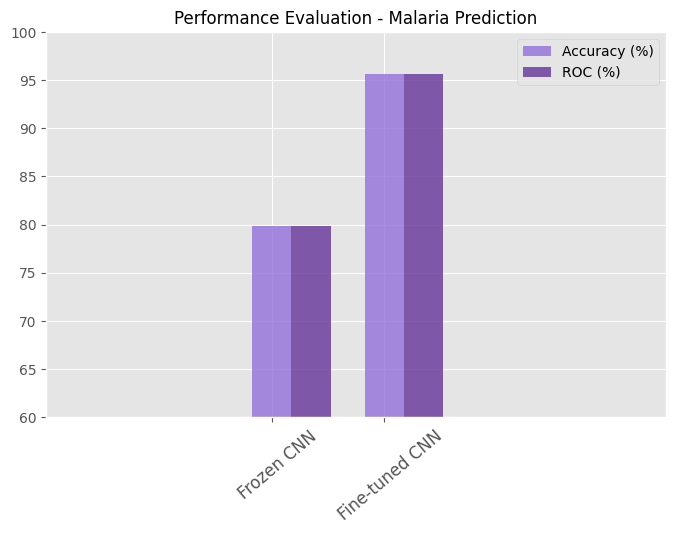

In [59]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_roc = [79.86, 95.65]
means_accuracy = [79.86, 95.65]
means_loss = [45.57, 12.14]

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 2
means_loss = tuple(means_loss)
means_accuracy = tuple(means_accuracy)
# means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

# rects1 = plt.bar(index, means_loss, bar_width,
# alpha=opacity,
# color='pink',
# label='Categorical crossentropy Loss (%)')

rects2 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects3 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-2, 3.5])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Malaria Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("/content/output5.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

[45.57, 12.14]


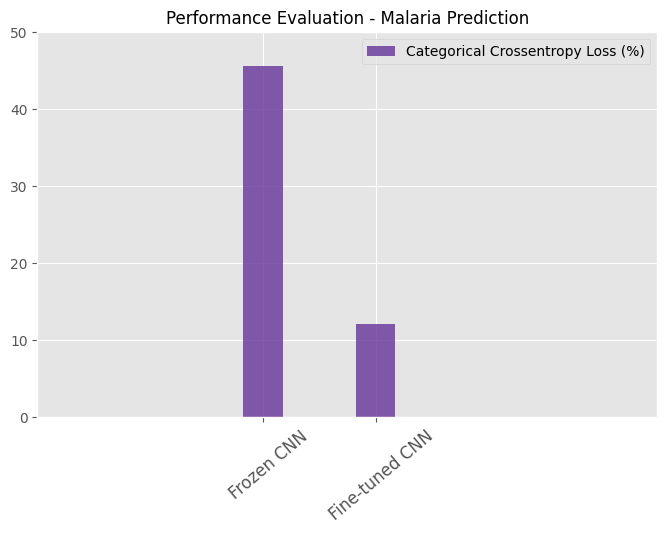

In [61]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'Frozen CNN',
    'model': model_01,
},
{
    'label': 'Fine-tuned CNN',
    'model': model_03,
}
]

means_loss = [45.57, 12.14]

print(means_loss)

# data to plot
n_groups = 2
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_loss, bar_width,
alpha=opacity,
color='rebeccapurple',
label='Categorical Crossentropy Loss (%)')

plt.xlim([-2, 3.5])
plt.ylim([0, 50])

plt.title('Performance Evaluation - Malaria Prediction', fontsize=12)
plt.xticks(index, ('   Frozen CNN', '   Fine-tuned CNN'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
# plt.legend(bbox_to_anchor =(1, 0.6), fontsize=12)
plt.savefig("/content/output6.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

In [62]:
test_images = [img for img in random.sample(infected_test_fpaths, 5)]
test_images.extend([img for img in random.sample(healthy_test_fpaths, 5)])

1/1 [==============================] - 0s 30ms/step


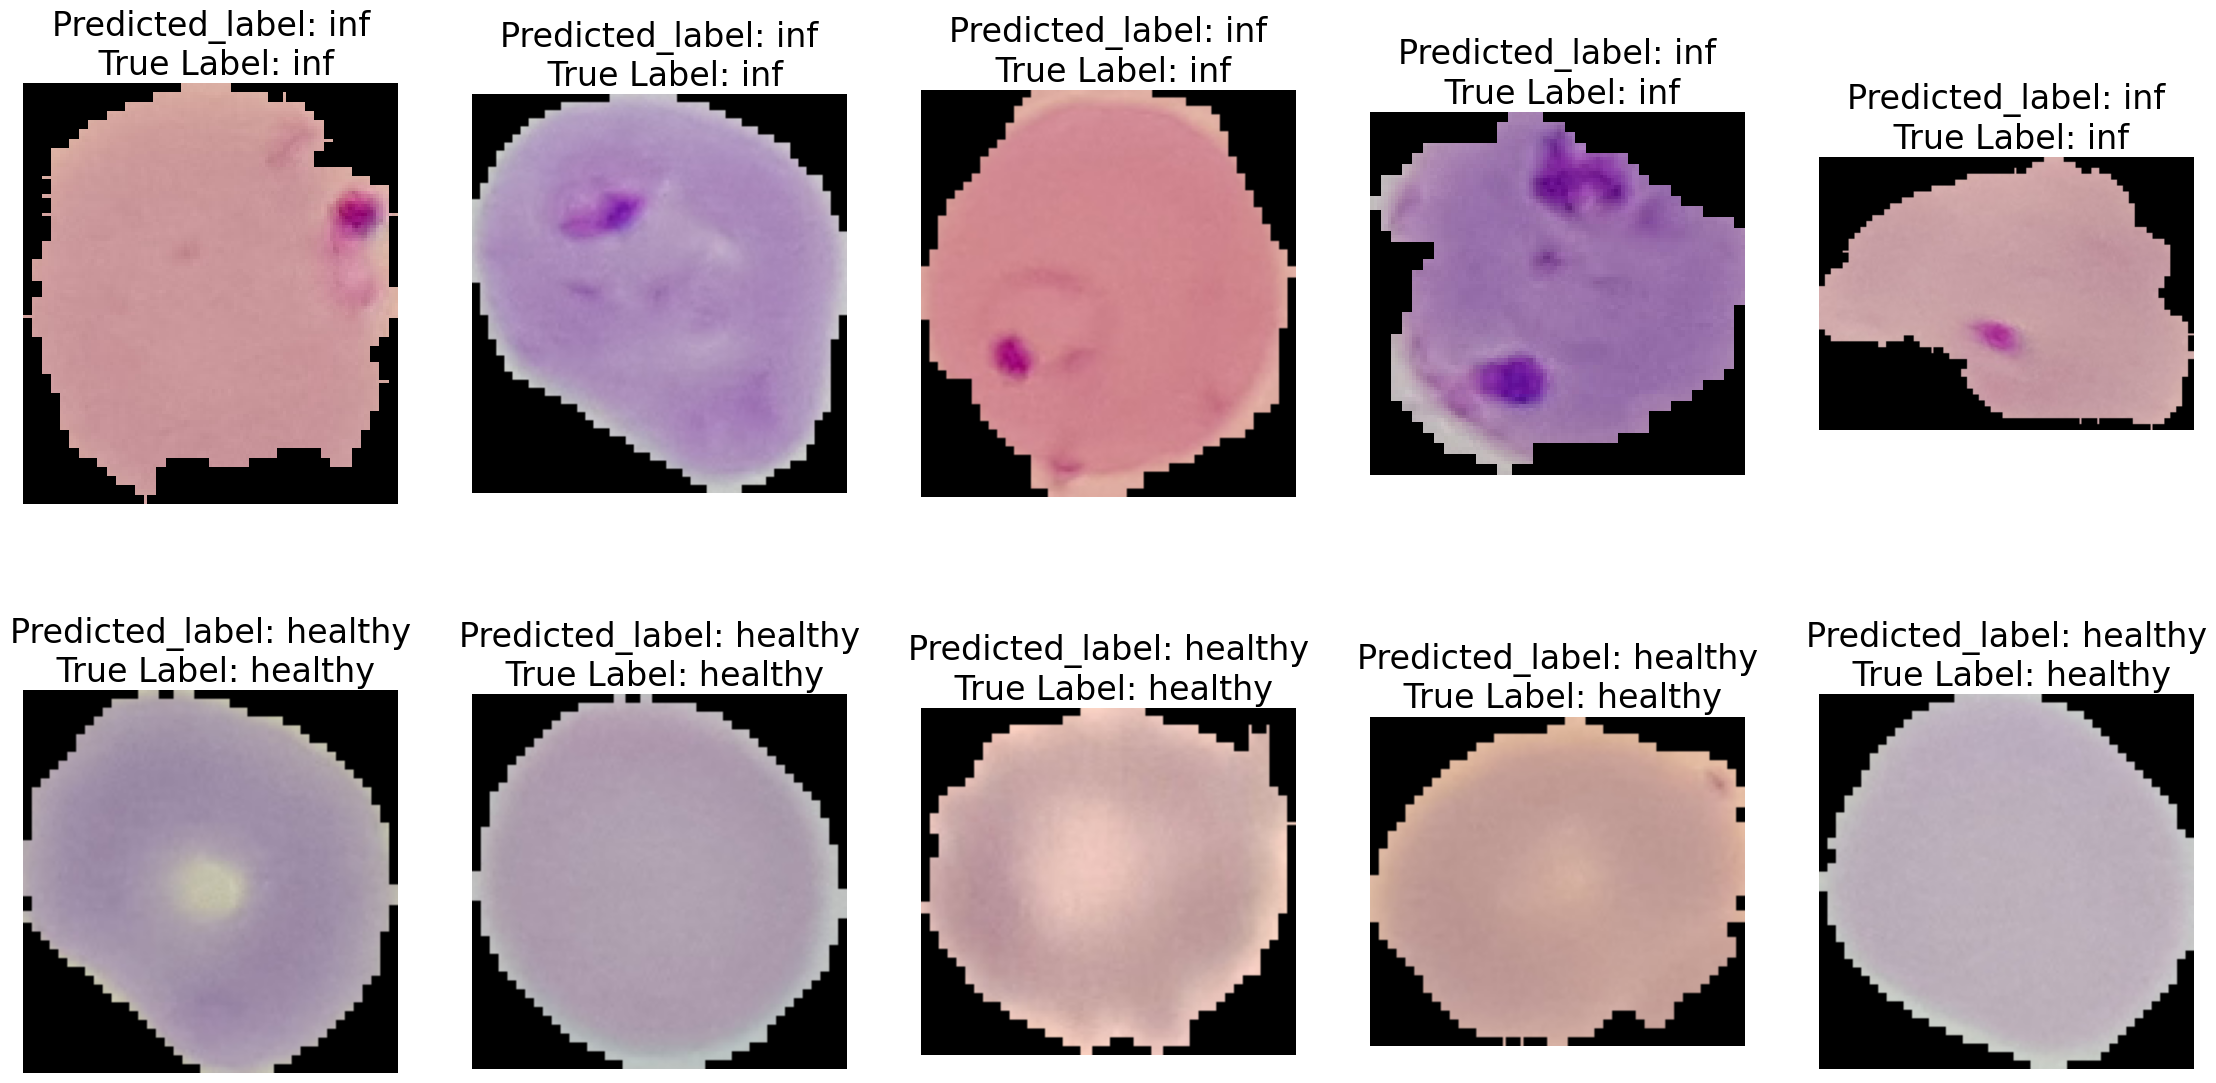

In [64]:
from keras.preprocessing.image import ImageDataGenerator
true_labels = []
predicted_labels = []
fig = plt.figure(figsize=(28,14))
columns=5
rows=2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    true_label = true_labels.append(test_images[i-1].split('/')[2])
    img = mpimg.imread(test_images[i-1])
    plt.imshow(img)
    plt.axis('off')
    img = tf.keras.utils.load_img(test_images[i-1], target_size=(128,128))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = model_03.predict(img)
    predicted_label = np.argmax(prediction)
    plt.title('Predicted_label: {}\n True Label: {}'.format(class_names[predicted_label], true_labels[i-1]), fontsize=24)
plt.savefig("/content/output7.png", format='png', dpi=400, bbox_inches='tight')
plt.show()